# "How many token generators do you usually put in a tokens deck, where the commander doesn't make tokens themselves?"

https://www.reddit.com/r/EDH/comments/1poh78x/how_many_token_generators_do_you_usually_put_in_a/

"I'm putting together a [[Fire Lord Zuko]] deck that aims to go wide with tokens and then use his ability to buff all of the tokens.

So I was wondering, how many token generators do you put in go wide decks, when the commander doesn't generate tokens themselves?"

## The Method

1. Download bulk card data from Scryfall.
2. Find commanders.
3. Filter commanders that don't generate tokens.
4. Filter cards that do make tokens.
5. Scrape commander deck data from Moxfield.
6. Filter decks whose commanders don't make tokens.
7. Filter decks whose theme is "Tokens".
8. Calculate average count of cards from step 4 in decks from step 7. 
9. Filter decks whose commander is Fire Lord Zuko.
10. Calculate average count of cards from step 4 in steps from step 9. 

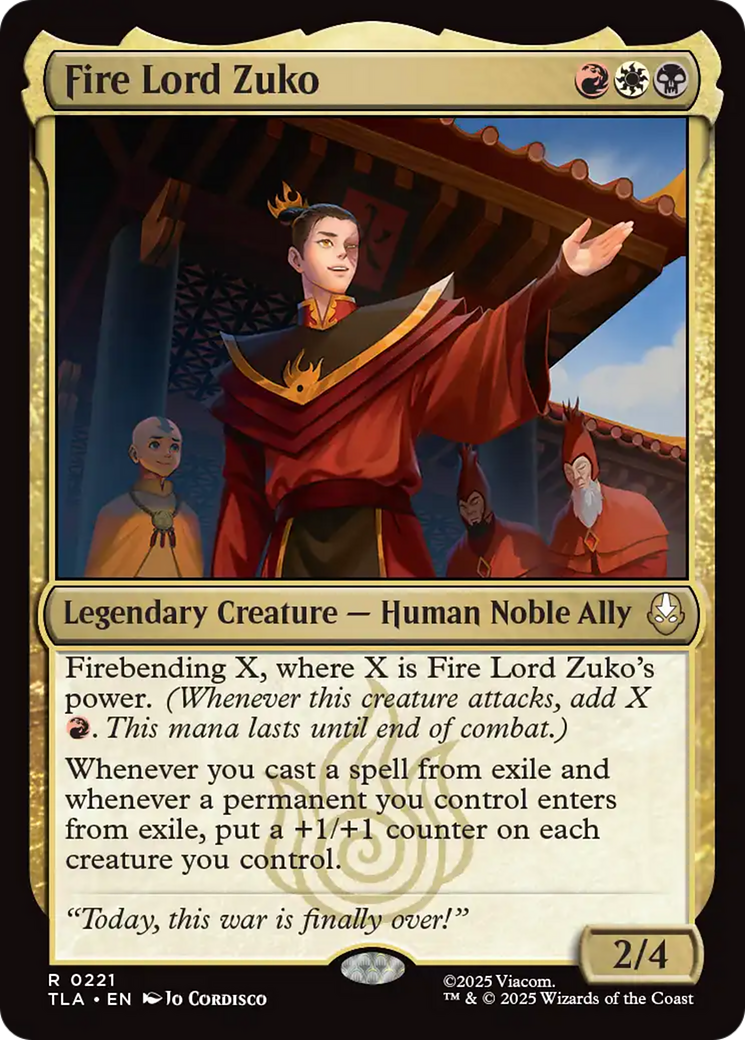

In [145]:
import re
import requests
from pprint import pprint

### 1. Download bulk card data from Scryfall.

In [146]:
def exhaustive_get(url):
    """If there is a page beyond the current page, this field will contain a full API URI to that page. 
    You may submit a HTTP GET request to that URI to continue paginating forward on this List."""
    resp = requests.get(url)
    assert resp.status_code == 200

    if type(resp.json()) is list:
        return resp.json()

    final_data = []
    while True:
        resp_data = resp.json()
        # print(resp_data["object"])
        final_data.extend(resp_data["data"])
        if resp_data["has_more"]:
            resp = requests.get(resp_data["next_page"])
            assert resp.status_code == 200
        else:
            break
    return final_data

In [147]:
bulk_data_items = exhaustive_get("https://api.scryfall.com/bulk-data")

In [148]:
for object in bulk_data_items:
    if object["name"] == "Oracle Cards":
        oracle_cards_uri = object["download_uri"]
        break

print(oracle_cards_uri)
oracle_cards = exhaustive_get(oracle_cards_uri)
print(f"Cards: {len(oracle_cards)}")


https://data.scryfall.io/oracle-cards/oracle-cards-20260205220317.json
Cards: 36708


In [158]:
oracle_cards = [card for card in oracle_cards if card["legalities"]["commander"] == "legal"]
print(f"Commander-legal cards: {len(oracle_cards)}")

Commander-legal cards: 30393


In [150]:
for card in oracle_cards:
    if card["name"] == "Archmage of Echoes":
        pprint(list(card.keys()))
        break

['object',
 'id',
 'oracle_id',
 'multiverse_ids',
 'mtgo_id',
 'tcgplayer_id',
 'cardmarket_id',
 'name',
 'lang',
 'released_at',
 'uri',
 'scryfall_uri',
 'layout',
 'highres_image',
 'image_status',
 'image_uris',
 'mana_cost',
 'cmc',
 'type_line',
 'oracle_text',
 'power',
 'toughness',
 'colors',
 'color_identity',
 'keywords',
 'legalities',
 'games',
 'reserved',
 'game_changer',
 'foil',
 'nonfoil',
 'finishes',
 'oversized',
 'promo',
 'reprint',
 'variation',
 'set_id',
 'set',
 'set_name',
 'set_type',
 'set_uri',
 'set_search_uri',
 'scryfall_set_uri',
 'rulings_uri',
 'prints_search_uri',
 'collector_number',
 'digital',
 'rarity',
 'flavor_text',
 'card_back_id',
 'artist',
 'artist_ids',
 'illustration_id',
 'border_color',
 'frame',
 'security_stamp',
 'full_art',
 'textless',
 'booster',
 'story_spotlight',
 'edhrec_rank',
 'prices',
 'related_uris',
 'purchase_uris']


### 2. Find commanders.

In [159]:
# Bulk Data doesn't have a field for whether a card is a commander, so we have to query separately
commanders = exhaustive_get("https://api.scryfall.com/cards/search?q=is%3Acommander")
print(f"Commanders: {len(commanders)}")
commanders = [card for card in commanders if card["legalities"]["commander"] == "legal"]
print(f"Commander-legal commanders: {len(commanders)}")

Commanders: 3086
Commander-legal commanders: 2846


In [152]:
token_keywords = [
    "Fabricate",
    "Afterlife",
    "Incubate",
    "Mobilize",
    "Endures",
    "Investigate",
    "Myriad",
    "Offspring",
    "Living weapon",
    "For Mirrodin!",
    "Job select",
    "Embalm",
    "Eternalize",
    "Encore",
    "Populate",
    "Squad",
    "Amass"
]

# Cards with token keywords that don't make tokens
false_positives = [
    "The Everflowing Well // The Myriad Pools",   # Myriad
    "Fiery Encore",   # Encore
    "Battle Squadron",   # Squad
    "Squadron Hawk",   # Squad
    "Whisper Squad",   # Squad
    "Vizier of the Anointed",   # Eternalize, Embalm
]

In [153]:
# Bulk Data doesn't have a field for full oracle text, so we have to query separately
other_token_text = [
    "becomes a token",
    "become tokens"
]

query = " OR ".join([f"fo:\"{text}\"" for text in other_token_text])
url_character_codes = {
    ":": "%3A",
    " ": "+"
}
for char, code in url_character_codes.items():
    query = query.replace(char, code)

url = f"https://api.scryfall.com/cards/search?q={query}"
becomes_token_cards = exhaustive_get(url)
print(len(becomes_token_cards))

49


### 3. Filter commanders that don't make tokens.

In [ ]:
def makes_token(card):
    for false_positive in false_positives:
        if card["name"] == false_positive:
            return False

    # Multi-faced cards
    if "oracle_text" in card:
        oracle_texts = [card["oracle_text"]]
    elif "card_faces" in card:
        oracle_texts = [face["oracle_text"] for face in card["card_faces"] if "oracle_text" in face]
    else:
        raise ValueError("Card has no oracle_text or card_faces")
    
    for oracle_text in oracle_texts:
        # Standard token creation pattern, i.e. "create a 1/1 green insect creature Soldier token"
        pattern = r"\bcreates?\b.*\btokens?\b"
        if re.search(pattern, oracle_text):
            return True

        # Check for other token keywords, i.e. "Fabricate 1"
        for token_keyword in token_keywords:
            pattern = rf"\b{token_keyword}\b"
            if re.search(pattern, oracle_text):
                return True

        # Check for other token phrases, i.e. "becomes a token"
        for text in other_token_text:
            if card["oracle_id"] in [c["oracle_id"] for c in becomes_token_cards]:
                return True
            
    return False

In [156]:
commanders_non_token = [commander for commander in commanders if not makes_token(commander)]
print(f"Commanders that don't make tokens: {len(commanders_non_token)}")

Commanders that don't make tokens: 2529


### 4. Filter cards that do make tokens.

In [160]:
cards_token = [card for card in oracle_cards if makes_token(card)]
print(f"Cards that make tokens: {len(cards_token)}")

Cards that make tokens: 2411


### 5. Scrape commander deck data from Moxfield.

### 6. Filter decks whose commanders don't make tokens.

### 7. Filter decks whose theme is "Tokens".

### 8. Calculate average count of cards from step 4 in decks from step 7.

### 9. Filter decks whose commander is Fire Lord Zuko.

### 10. Calculate average count of cards from step 4 in decks from step 9.